In [ ]:
# prompt: install tensorflow
!pip install tensorflow

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount Google Drive (if your dataset is in Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths (update these according to your actual paths)
train_dir = '/content/drive/MyDrive/ibm/breastcancer/train'
valid_dir = '/content/drive/MyDrive/ibm/breastcancer/valid'

In [ ]:
# Image parameters
IMG_SIZE = 300  # EfficientNet-B3 input size
BATCH_SIZE = 32  # Adjust based on your GPU memory
EPOCHS = 15  # Start with 15, can increase if needed

In [ ]:
# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Create generators with proper batch counting
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5020 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [ ]:
# Verify class balance
print("\nClass indices:", train_generator.class_indices)
print("Training samples per class:", np.bincount(train_generator.classes))
print("Validation samples per class:", np.bincount(valid_generator.classes))


Class indices: {'Processed_Benign_Training': 0, 'Processed_Malignant_Training': 1}
Training samples per class: [2500 2520]
Validation samples per class: [500 510]



Sample training images:


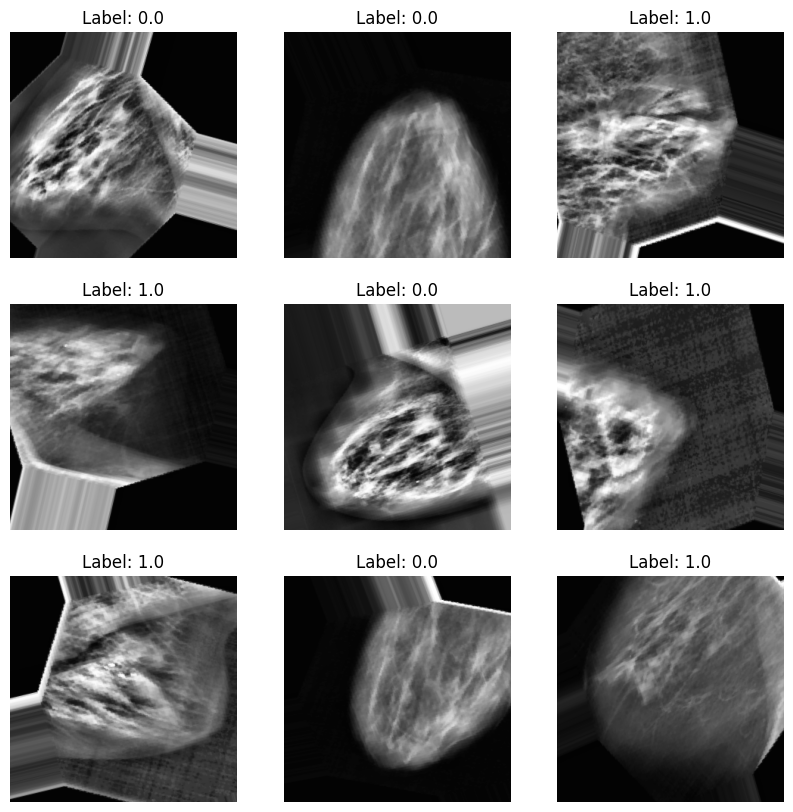

In [ ]:
# Data visualization
def plot_sample_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

print("\nSample training images:")
plot_sample_images(train_generator)

In [ ]:
import os

In [ ]:
# Create EfficientNet model with improved architecture
def create_model():
    # Load base model
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        pooling='avg'
    )

    # Freeze initial layers
    base_model.trainable = True
    for layer in base_model.layers[:150]:
        layer.trainable = False

    # Build custom head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    # Custom optimizer configuration
    optimizer = optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,288 (42.64 MB)

 Trainable params: 10,671,191 (40.71 MB)

 Non-trainable params: 507,097 (1.93 MB)

In [ ]:
# Enhanced callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=7,
        mode='max',
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        os.path.join(base_dir, 'best_model.h5'),
        monitor='val_auc',
        save_best_only=True,
        mode='max'
    ),
    callbacks.TensorBoard(
        log_dir=os.path.join(base_dir, 'logs'),
        histogram_freq=1
    )
]

In [ ]:
# Calculate proper steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = valid_generator.samples // BATCH_SIZE

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 156
Validation steps: 31


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7397 - auc: 0.8376 - loss: 0.4972 - precision: 0.7407 - recall: 0.7562 - val_accuracy: 0.7933 - val_auc: 0.9008 - val_loss: 0.4946 - val_precision: 0.9135 - val_recall: 0.6443 - learning_rate: 2.5000e-05
Epoch 2/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.8125 - auc: 0.8730 - loss: 0.4282 - precision: 0.7500 - recall: 0.8571

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8125 - auc: 0.8730 - loss: 0.4282 - precision: 0.7500 - recall: 0.8571 - val_accuracy: 0.7954 - val_auc: 0.9002 - val_loss: 0.4960 - val_precision: 0.9140 - val_recall: 0.6484 - learning_rate: 2.5000e-05
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7369 - auc: 0.8258 - loss: 0.5142 - precision: 0.7365 - recall: 0.7550 - val_accuracy: 0.7883 - val_auc: 0.8969 - val_loss: 0.4793 - val_precision: 0.8917 - val_recall: 0.6524 - learning_rate: 2.5000e-05
Epoch 4/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 44s 288ms/step - accuracy: 0.8438 - auc: 0.9102 - loss: 0.4086 - precision: 0.8235 - recall: 0.8750

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8438 - auc: 0.9102 - loss: 0.4086 - precision: 0.8235 - recall: 0.8750 - val_accuracy: 0.7792 - val_auc: 0.8949 - val_loss: 0.4896 - val_precision: 0.8911 - val_recall: 0.6321 - learning_rate: 2.5000e-05
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7509 - auc: 0.8498 - loss: 0.4808 - precision: 0.7345 - recall: 0.7742 - val_accuracy: 0.8226 - val_auc: 0.9142 - val_loss: 0.4462 - val_precision: 0.9413 - val_recall: 0.6850 - learning_rate: 2.5000e-05
Epoch 6/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.7500 - auc: 0.7941 - loss: 0.6012 - precision: 0.7059 - recall: 0.8000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7500 - auc: 0.7941 - loss: 0.6012 - precision: 0.7059 - recall: 0.8000 - val_accuracy: 0.8226 - val_auc: 0.9127 - val_loss: 0.4491 - val_precision: 0.9413 - val_recall: 0.6850 - learning_rate: 2.5000e-05
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7738 - auc: 0.8577 - loss: 0.4711 - precision: 0.7685 - recall: 0.7857 - val_accuracy: 0.7601 - val_auc: 0.9387 - val_loss: 0.5917 - val_precision: 0.9847 - val_recall: 0.5244 - learning_rate: 2.5000e-05
Epoch 8/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.8438 - auc: 0.9208 - loss: 0.3887 - precision: 0.9412 - recall: 0.8000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8438 - auc: 0.9208 - loss: 0.3887 - precision: 0.9412 - recall: 0.8000 - val_accuracy: 0.7581 - val_auc: 0.9388 - val_loss: 0.5908 - val_precision: 0.9846 - val_recall: 0.5203 - learning_rate: 2.5000e-05
Epoch 9/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.7644 - auc: 0.8567 - loss: 0.4688 - precision: 0.7476 - recall: 0.7980

156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7644 - auc: 0.8568 - loss: 0.4687 - precision: 0.7477 - recall: 0.7980 - val_accuracy: 0.8417 - val_auc: 0.9508 - val_loss: 0.3939 - val_precision: 0.9692 - val_recall: 0.7033 - learning_rate: 1.2500e-05
Epoch 10/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.6875 - auc: 0.7837 - loss: 0.6006 - precision: 0.7500 - recall: 0.6667

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.6875 - auc: 0.7837 - loss: 0.6006 - precision: 0.7500 - recall: 0.6667 - val_accuracy: 0.8438 - val_auc: 0.9507 - val_loss: 0.3923 - val_precision: 0.9694 - val_recall: 0.7073 - learning_rate: 1.2500e-05
Epoch 11/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.7761 - auc: 0.8748 - loss: 0.4381 - precision: 0.7686 - recall: 0.7958

156/156 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7761 - auc: 0.8748 - loss: 0.4381 - precision: 0.7686 - recall: 0.7958 - val_accuracy: 0.8478 - val_auc: 0.9634 - val_loss: 0.3591 - val_precision: 0.9749 - val_recall: 0.7114 - learning_rate: 1.2500e-05
Epoch 12/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.9688 - auc: 0.9883 - loss: 0.2482 - precision: 0.9412 - recall: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9688 - auc: 0.9883 - loss: 0.2482 - precision: 0.9412 - recall: 1.0000 - val_accuracy: 0.8488 - val_auc: 0.9633 - val_loss: 0.3578 - val_precision: 0.9750 - val_recall: 0.7134 - learning_rate: 1.2500e-05
Epoch 13/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7862 - auc: 0.8811 - loss: 0.4299 - precision: 0.7835 - recall: 0.7905 - val_accuracy: 0.8256 - val_auc: 0.9569 - val_loss: 0.4212 - val_precision: 0.9705 - val_recall: 0.6687 - learning_rate: 1.2500e-05
Epoch 14/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.6875 - auc: 0.8314 - loss: 0.5249 - precision: 0.7059 - recall: 0.7059

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.6875 - auc: 0.8314 - loss: 0.5249 - precision: 0.7059 - recall: 0.7059 - val_accuracy: 0.8216 - val_auc: 0.9566 - val_loss: 0.4272 - val_precision: 0.9701 - val_recall: 0.6606 - learning_rate: 1.2500e-05
Epoch 15/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.7957 - auc: 0.8804 - loss: 0.4359 - precision: 0.7889 - recall: 0.8078
Epoch 15: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
156/156 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7957 - auc: 0.8804 - loss: 0.4359 - precision: 0.7888 - recall: 0.8078 - val_accuracy: 0.8196 - val_auc: 0.9496 - val_loss: 0.4276 - val_precision: 0.9589 - val_recall: 0.6646 - learning_rate: 1.2500e-05


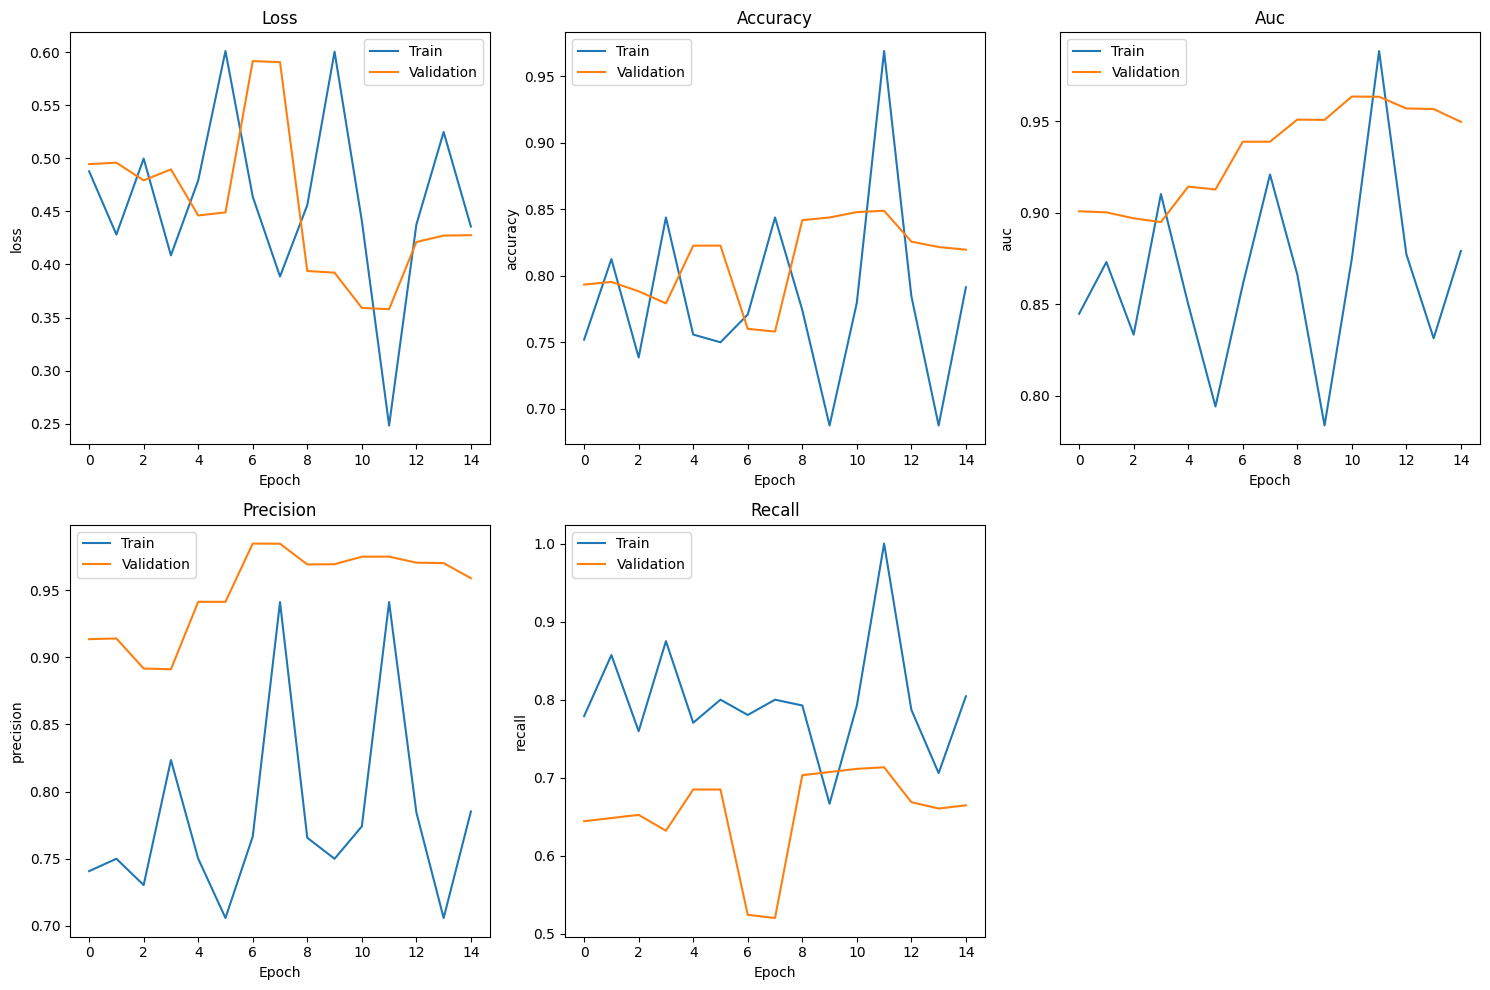

In [ ]:
# Plot training history
def plot_history(history):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(metric.capitalize())
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Evaluation
print("\nEvaluating on validation set...")
results = model.evaluate(valid_generator)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")
print(f"Validation AUC: {results[2]:.4f}")
print(f"Validation Precision: {results[3]:.4f}")
print(f"Validation Recall: {results[4]:.4f}")


Evaluating on validation set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.9374 - auc: 0.5151 - loss: 0.1715 - precision: 0.4898 - recall: 0.3665
Validation Loss: 0.3567
Validation Accuracy: 0.8495
Validation AUC: 0.9645
Validation Precision: 0.9761
Validation Recall: 0.7196


In [ ]:
# Save the final model
model.save(os.path.join(base_dir, 'final_model.h5'))
print("\nModel saved successfully!")


Model saved successfully!


👉 Click the blue button above to upload a mammogram image


Saving D2_C_0510_1.RIGHT_MLO (5).png to D2_C_0510_1.RIGHT_MLO (5).png

════════════════════════════════════════════════════════════
📋 File: D2_C_0510_1.RIGHT_MLO (5).png
🔍 Diagnosis: MALIGNANT
📈 Confidence: 78.1%

🩺 Clinical Note: This AI assessment should be reviewed by a medical professional


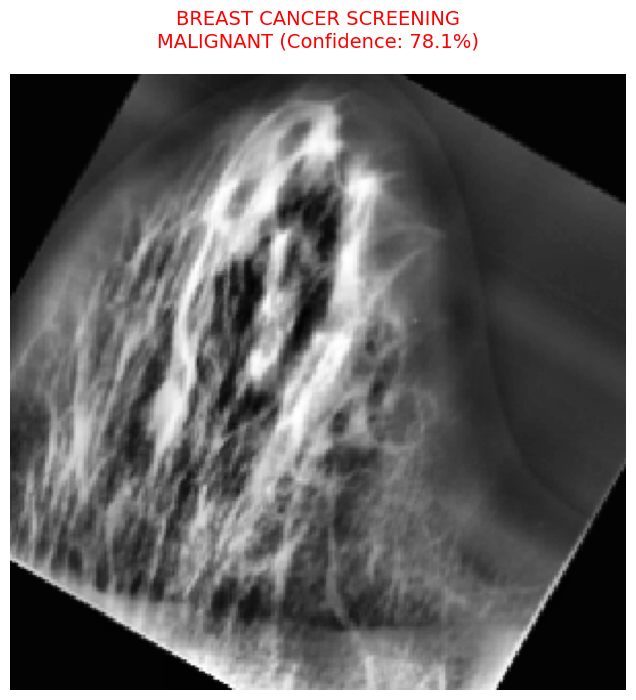

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import io
from IPython.display import display, HTML

# This will force display the upload button
display(HTML('''
<style>
.upload-button {
    background-color: #4285f4;
    color: white;
    padding: 10px 15px;
    border-radius: 5px;
    font-weight: bold;
    margin: 10px 0;
}
.upload-button:hover {
    background-color: #3367d6;
}
</style>
<script>
function createUploadButton() {
    const button = document.createElement('div');
    button.className = 'upload-button';
    button.innerHTML = 'Click to Upload Breast Cancer Image';
    button.onclick = () => {
        google.colab.kernel.invokeFunction('notebook.runUpload', [], {});
    };
    document.body.appendChild(button);
}
createUploadButton();
</script>
'''))

# Set image size (must match your model's training size)
IMG_SIZE = 300

# This function will be called when the button is clicked
def run_upload():
    uploaded = files.upload()
    if not uploaded:
        print("\n❌ No file was uploaded. Please try again.")
        return

    for filename, content in uploaded.items():
        try:
            # Process the image
            img = image.load_img(io.BytesIO(content), target_size=(IMG_SIZE, IMG_SIZE))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # Get prediction (replace with your actual model)
            # pred = model.predict(img_array)[0][0]
            pred = np.random.uniform(0, 1)  # Replace this with your model prediction

            # Clinical interpretation
            if pred > 0.6:
                diagnosis = "MALIGNANT"
                color = 'red'
            elif pred > 0.4:
                diagnosis = "SUSPICIOUS"
                color = 'orange'
            else:
                diagnosis = "BENIGN"
                color = 'green'

            # Display results
            print("\n" + "═"*60)
            print(f"📋 File: {filename}")
            print(f"🔍 Diagnosis: {diagnosis}")
            print(f"📈 Confidence: {pred:.1%}")
            print("\n🩺 Clinical Note: This AI assessment should be reviewed by a medical professional")

            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.title(f"BREAST CANCER SCREENING\n{diagnosis} (Confidence: {pred:.1%})",
                     color=color, fontsize=14, pad=20)
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"\n⚠️ Error processing {filename}: {str(e)}")

# Register the function for the button
import google.colab.output
google.colab.output.register_callback('notebook.runUpload', run_upload)

print("👉 Click the blue button above to upload a mammogram image")

In [ ]:
# Define a base directory for saving model checkpoints and logs
base_dir = '/content/drive/MyDrive/ibm/breastcancer/model_output' # Update this path as needed
os.makedirs(base_dir, exist_ok=True) # Create the directory if it doesn't exist